<a href="https://colab.research.google.com/github/XiangxiangXu/NFL/blob/main/Nested_H_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Nested H-Score Network

A demo for [![blog](https://img.shields.io/badge/blog-gilearning.github.io-black)](https://gilearning.github.io/)

This is a supporting demo for this [post](https://gilearning.github.io/NestedHScore/) on the nested H-score network. The goal is to learn multiple modes from a dataset simultaneously.

We use the same small synthesized dataset used in the previous demos on [modal decomposition](https://colab.research.google.com/drive/1n4qk69shPL0LvGcaUJ4WIeJJRdyp2zA-?usp=sharing) and on [the H-score network](https://colab.research.google.com/drive/1unwIT5Y23_2owWVlFuRvIL4yCtbhuQOo?usp=sharing), with the only change of learning multiple pairs of feature functions together, instead of just the one dominating mode.



### Preparation
We specify that in the hyper-parameters by adding the line $\mathtt{dim=3}$.

This is the first demo that an H-score based procedure does something that a common neural network cannot. If we were to learn a 3-dimensional feature of the data with a neural network, the result would be linear combinations of the top three features. The neural network would not separate the learned features into orthogonal single dimensional ones, making the learned result less flexible to use. The goal of using the nested H-score network here is to show that by making the feature space projections with the nested network, we can separate the features.

In [ ]:
import numpy as np
import torch

# cardinalities
x_card, y_card = (8, 6)

# number of samples
nSamples = 30000

# batch size
batchsize = 128

# number of epochs
nEpochs = 100

# number of modes
dim = 3

### Data Generation and Theoretical Computation

The data generation and the theoretical computation of the modal decomposition are the same as the previous demos. Note that the theoretic results, $\mathtt{f\_theory, g\_theory}$ computed here are from a full SVD of the model, and thus contains more modes than we will compute. We will later only read out some of these feature functions to make comparison.

In [ ]:
# Fixing random state for reproducibility
np.random.seed(20230606)
# randomly pick joint distribution, normalize
p_xy = np.random.random([x_card, y_card])
p_xy = p_xy / np.sum(p_xy)

"""
Generate random discrete samples
"""
def GenerateDiscreteSamples(p_xy, nSamples):

    (x_card, y_card) = p_xy.shape
    p_xy_vec = p_xy.reshape(-1)  # p_xy_vec is the PMF of key = Y * cX + X
    key = np.random.choice(range(x_card*y_card), nSamples, p=p_xy_vec)
    X = (key / y_card).astype(int)
    Y = (key % y_card)

    return([X, Y])

class oracle:
    def t2mat(self, p): # map tensor to mat
        return p.reshape(p.shape[0], p.shape[1])
    # p_mat should be an x by y mat. return px, py.
    def get_margins(self, p_mat):
        return np.sum(p_mat, axis = 1), np.sum(p_mat, axis = 0)
    def p2bt(self, p_mat):
        p_x, p_y = self.get_margins(p_mat)
        p_x = p_x.reshape(-1, 1)
        p_y = p_y.reshape(1, -1)
        bt_mat = p_mat / np.sqrt(p_x) / np.sqrt(p_y) - np.sqrt(p_x) * np.sqrt(p_y)
        bt_mat[np.isnan(bt_mat)] = 0
        return bt_mat

    def loss(self, dim):
        # predict the theretical value of loss
        w_vec = dim - np.array(range(dim))
        val = - np.sum(w_vec * (self.sigma[:dim] ** 2))
        val = val / 2
        return val


    def comp_mc(self, bt, p_x, p_y):
        '''
            Compute oracle answers for f and g, corresponding to the
            of singular vectors of B
            '''
        Phi, sigma, Psi = np.linalg.svd(bt)
        Psi = Psi.T
        f = Phi / np.sqrt(p_x).reshape(-1, 1)
        g = Psi / np.sqrt(p_y).reshape(-1, 1)
        return f, g, sigma

    def __init__(self, p):
        self.p = p
        # compute marginals
        self.p_x = np.sum(p, axis = 1)
        self.p_y = np.sum(p, axis = 0)


        p_mat = self.t2mat(p)
        self.bt = self.p2bt(p_mat) # b_x;y

        p_x, p_y = self.get_margins(p_mat)

        self.f, self.g, self.sigma = self.comp_mc(self.bt, self.p_x, self.p_y)

orc = oracle(p_xy)
f_theory = orc.f
g_theory = orc.g
sigma_theory = orc.sigma

### Data Preparation

The data generation is also the same as before.

In [ ]:
[X, Y] = GenerateDiscreteSamples(p_xy, nSamples)

import torch.nn.functional as F
Xt = torch.tensor (X)
Xt = F.one_hot(Xt, x_card).type(torch.FloatTensor)
Yt = torch.tensor (Y)
Yt = F.one_hot(Yt, y_card).type(torch.FloatTensor)

from torch.utils.data import TensorDataset, DataLoader

ds = TensorDataset(Xt, Yt)
dl = DataLoader(ds, batch_size=batchsize, shuffle = True)

### Packaging the Sub-Networks

The packaging of the two sub-networks is also the same as before: $\mathtt{fg\_nn}$ contains two sub-networks, one for $f$ features, and the other for $g$ features. The only slight difference is in the definition of the sub-networks, $\mathtt{f\_net = fc\_net(dim, x\_card)}$, and the line for $\mathtt{g\_net}$, where we specify the output dimension of the sub-networks to be $\mathtt{dim = 3}$, so $3$ pairs of feature functions will be generated.

In [ ]:
from torch import nn, optim

class fc_net(nn.Module): # fully connected
    def __init__(self, fdim, num_classes):
        super().__init__()
        self.fc = nn.Linear(num_classes, fdim)

    def forward(self, x):
        f = self.fc(x)
        return f

class fg_nn(nn.Module):
    def __init__(self, f_net, g_net):
        super().__init__()

        self.f_net = f_net
        self.g_net = g_net

    def forward(self, x, y):
        f = self.f_net(x)
        g = self.g_net(y)
        return f, g

    def get_f(self, x):
        f = self.f_net(x)
        return f

    def get_g(self, y):
        g = self.g_net(y)
        return g

f_net = fc_net(dim, x_card)
g_net = fc_net(dim, y_card)

model = fg_nn(f_net, g_net)
opt = optim.Adam(model.parameters())

### Nested H-Score

The key is in the definition of $\mathtt{neg_hscore_nest}$, where we define the loss function as the sum of three H-scores of different sizes. This specifies the nested structure.

In [ ]:
centralize = lambda x: x - torch.mean(x, 0) # zero-mean
cov = lambda x: x.T @ x / (x.size()[0]-1.) # covariance

def neg_hscore(f, g):
    """
    compute the negative h-score
    """
    f0 = centralize(f)
    g0 = centralize(g)
    corr = torch.mean(torch.sum(f0*g0, 1))
    # to generate zero-mean f, g
    cov_f = cov(f)
    cov_g = cov(g)
    return - corr + torch.trace(cov_f @ cov_g) / 2.

def neg_hscore_nest(f, g, dim0 = 0):
    """
    compute the (nagative) nested H-score:

    from dim0
    """
    f_dim = f.shape[1]
    neg_h_nest = torch.sum(torch.stack(
        [neg_hscore(f[:, :i+1], g[:, :i+1])
         for i in range(dim0, f_dim)]))
    return neg_h_nest

### Training, Reading Feature Functions, and Plotting

Again, all the same as before, just the dimension of the results changed.

In [ ]:
for epoch in range(nEpochs):
    for x, y in dl:
        f, g = model(x, y)
        loss = neg_hscore_nest(f, g)
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print('training neg_h_score =', loss)


In [ ]:
# trained values
f_trained = model.get_f(torch.eye(x_card)).detach().numpy()
g_trained = model.get_g(torch.eye(y_card)).detach().numpy()

# get features on the training set
f_trained_all = model.get_f(Xt).detach().numpy()
g_trained_all = model.get_g(Yt).detach().numpy()

# compute stand deviations for each dimension
std_f = np.zeros(dim)
std_g = np.zeros(dim)
for i in range(dim):
    std_f[i] = np.std(f_trained_all[:, i])
    std_g[i] = np.std(g_trained_all[:, i])

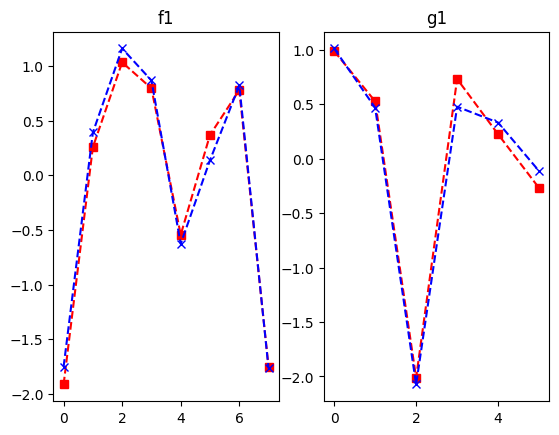

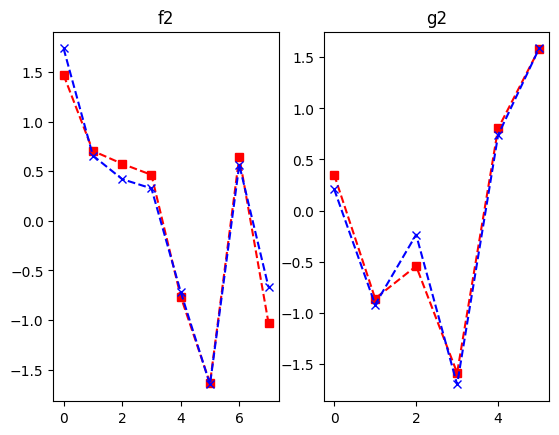

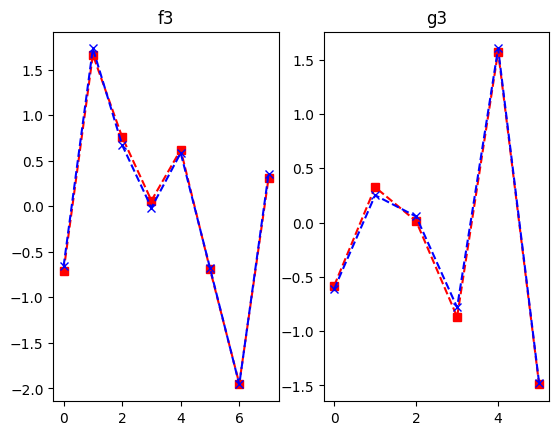

In [ ]:
import matplotlib.pyplot as plt

sign_ip = lambda v1, v2: np.sign(np.sum(v1.squeeze() * v2.squeeze()))
# compute the sign of inner product

for i in range(dim):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(np.arange(x_card), f_theory[:,i], 'rs--')
    f_trained_n = f_trained[:,i]/std_f[i]      # normalized f
    sign = sign_ip(f_theory[:,i], f_trained_n) # align with the direction
    ax1.plot(np.arange(x_card), f_trained_n * sign, 'bx--')
    ax1.set_title('f'+str(i+1))
    ax2.plot(np.arange(y_card), g_theory[:,i], 'rs--')
    g_trained_n = g_trained[:,i]/std_g[i]      # normalized g
    sign = sign_ip(g_theory[:,i], g_trained_n) # align with the direction
    ax2.plot(np.arange(y_card), g_trained_n * sign, 'bx--')
    ax2.set_title('g'+str(i+1))
plt.show()

Learned singualr values.

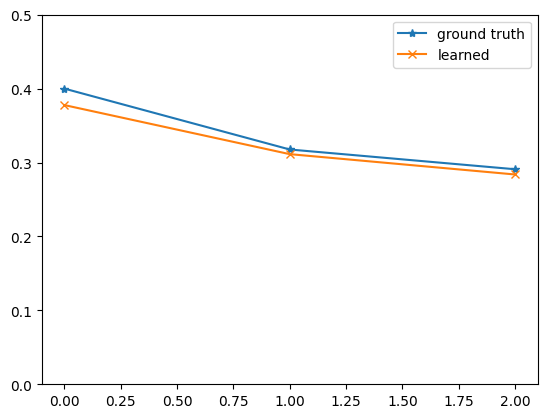

In [ ]:
plt.plot(orc.sigma[:dim], '*-', label = 'ground truth')
plt.plot(std_f * std_g, 'x-', label = 'learned')
plt.ylim([0, .5])
plt.legend()